***
## Библиотеки и исходные данные.

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

Импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Посмотрим на наши признаки:

**Данные о клиенте и таксопарке:**
* *id* - уникальный идентификатор поездки
* *vendor_id* - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* *pickup_datetime* - дата и время, когда был включен счетчик поездки
* *dropoff_datetime* - дата и время, когда счетчик был отключен

**Географическая информация:**
* *pickup_longitude* -  долгота, на которой был включен счетчик
* *pickup_latitude* - широта, на которой был включен счетчик
* *dropoff_longitude* - долгота, на которой счетчик был отключен
* *dropoff_latitude* - широта, на которой счетчик был отключен

**Прочие признаки:**
* *passenger_count* - количество пассажиров в транспортном средстве (введенное водителем значение)
* *store_and_fwd_flag* - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* *trip_duration* - продолжительность поездки в секундах

Переведём признак ***pickup_datetime*** в тип данных *datetime* с форматом *год-месяц-день* *час:минута:секунда*: 

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Посмотрим на пропуски:

In [5]:
taxi_data.isna().mean()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

Отлично, пропусков нет.

Посмотрим на наши данные поближе:

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [12]:
# настроим вывод
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [13]:
cols_describe = ['passenger_count', 'trip_duration']
taxi_data[cols_describe].describe()

passenger_count  trip_duration
count       1458644.00     1458644.00
mean              1.66         959.49
std               1.31        5237.43
min               0.00           1.00
25%               1.00         397.00
50%               1.00         662.00
75%               2.00        1075.00
max               9.00     3526282.00

Посмотрим на среднее и медиану признака ***trip_duartion***:

In [21]:
print(f'Среднее время поездки: {taxi_data.trip_duration.mean()}')
print(f'Медианное время поездки: {taxi_data.trip_duration.median()}')

Среднее время поездки: 959.4922729603659
Медианное время поездки: 662.0


Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы. При дальнейшем анализе выяснится, что у нас также есть «телепортации» — поездки, которые были проделаны за секунды на большие расстояния.

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

**Примечание**. На основе полученной статистической информации о целевом признаке *trip_duration* мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как [усечённое среднее](https://en.wikipedia.org/wiki/Truncated_mean), [логарифмическое среднее](https://en.wikipedia.org/wiki/Logarithmic_mean) или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Реализуем функцию *add_datetime_features()*, которая принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* *pickup_date* - дата включения счетчика - начала поездки (без времени);
* *pickup_hour* - час дня включения счетчика;
* *pickup_day_of_week* - наименование дня недели, в который был включен счетчик.

In [22]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    data['pickup_date'] = data['pickup_date'].astype(str)
    return data

taxi_data = add_datetime_features(taxi_data)

Также реализуем функцию *add_holiday_features()*, которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом *pickup_holiday* - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет):

In [24]:
# прочитаем датасет с праздниками:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(data, holiday_data):
    data = data.merge(
        holiday_data['date'],
        how='left',
        left_on='pickup_date',
        right_on='date'
    )
    data = data.rename(columns={'date':'pickup_holiday_'})
    data['pickup_holiday'] = ~data['pickup_holiday_'].isna()
    data['pickup_holiday'] = data['pickup_holiday'].astype(int)
    data = data.drop('pickup_holiday_', axis=1)
    return data

taxi_data = add_holiday_features(taxi_data, holiday_data)

Отлично, мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться **OSRM API**.

[**OSRM (Open Source Routing Machine)**](https://en.wikipedia.org/wiki/Open_Source_Routing_Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет не только построить оптимальный кусочно-линейный путь из точки *А* в точку *B*, но также узнать его примерную длительность, длину, а также подробную информацию о количестве шагов, которые необходимо преодолеть по пути (количество поворотов). У данного сервиса есть *API*, с которым вы можете познакомиться в [документации](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/).

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью *API* и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из *OSRM API* для каждой поездки из тренировочной и тестовой выборок нашего набора данных.

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [211]:
# ваш код здесь
osrm_data = pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(data, osrm):
    data = data.merge(
        osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']],
        how='left', 
        on='id'
    )
    return data

taxi_data = add_osrm_features(taxi_data, osrm_data)

In [212]:
round(taxi_data['total_travel_time'].median() - taxi_data['trip_duration'].median(), 0)

-372.0

In [213]:
taxi_data['total_distance'].isna().sum()

1

Введём в наш анализ расстояние по [формуле гаверсинуса](https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/). 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

![project-5](\images\p5-1.png)

Пусть есть две точки с географическими координатами $x_1 = (\varphi_1, \lambda_1)$ и $x_2 = (\varphi_2, \lambda_2)$, где
- $\varphi_1$ и $\lambda_1$ — широта (*latitude*) и долгота (*longitude*) первой точки маршрута (в радианах);
- $\varphi_2$ и $\lambda_2$ — широта (*latitude*) и долгота (*longitude*) второй точки маршрута (в радианах).

Тогда расстояние по формуле гаверсинуса (в километрах) определяется как:

$$h(x_1,x_2) = 2R \ arcsin (\sqrt{sin^2 (\frac{\varphi_2 - \varphi_1}{2}) + cos(\varphi_1) cos(\varphi_2) sin (\frac{\lambda_2 - \lambda_1}{2})}),$$

где $R$ — радиус земли (6371 км), $h$ — расстояние между двумя точками на сфере (в километрах).

В чём разница между расстоянием по формуле гаверсинуса и расстоянием из *OSRM*? Расстояние, вычисляемое в *OSRM*, — это кратчайший суммарный путь, пройденный по дорожным разметкам.

Взгляните на карту ниже. Если принять Землю за плоскость, то можно показать, что расстояние по формуле гаверсинуса превратится в евклидово расстояние. Тогда величина $h$ будет длиной гипотенузы прямоугольного треугольника (на карте ниже она обозначена зелёным), а вот расстояние из *OSRM* будет равно сумме длин катетов (на карте обозначено чёрным).

![project-5](\images\p5-2.png)

Далее, зная начальную и конечную точку маршрута, мы можем вычислить направление движения автомобиля (угол пеленга) по формуле:

$$\alpha = arctg (\frac{sin (\lambda_2 - \lambda_1) cos (\varphi_2)}{cos (\varphi_1) sin (\varphi_2) - sin (\varphi_1) cos (\varphi_2) cos (\lambda_2 - \lambda_1)}),$$

где $\alpha$ — угол направления движения от первой точки ко второй (может измеряться как в радианах, так и в градусах).

В интернете можно найти множество реализаций введённых нами формул на разных языках, в том числе на *Python*. Мы предлагаем вам воспользоваться следующими функциями:
- *get_haversine_distance* — функция для вычисления расстояния по формуле гаверсинуса (в километрах);
- *get_angle_direction* — функция для вычисления угла направления движения (в градусах).

In [214]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [215]:
# ваш код здесь
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    return data

taxi_data = add_geographical_features(taxi_data)

In [216]:
taxi_data['haversine_distance'].median()

2.0937171329263693

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом *K-Means*. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [217]:
a = np.array([ 40.76793671, -73.98215485,  40.76560211, -73.96463013])

In [218]:
a

array([ 40.76793671, -73.98215485,  40.76560211, -73.96463013])

In [219]:
b = a.reshape(1, -1)

In [220]:
b.shape

(1, 4)

In [221]:
c = kmeans.predict(b)

In [222]:
c

array([1])

In [223]:
coords

array([[ 40.76793671, -73.98215485,  40.76560211, -73.96463013],
       [ 40.73856354, -73.98041534,  40.73115158, -73.9994812 ],
       [ 40.7639389 , -73.97902679,  40.71008682, -74.00533295],
       ...,
       [ 40.76879883, -73.95912933,  40.70737076, -74.00443268],
       [ 40.74906158, -73.98207855,  40.75710678, -73.97463226],
       [ 40.78174973, -73.97953796,  40.79058456, -73.97280884]])

In [224]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# ваш код здесь
def add_cluster_features(data, cluster):
    coords_ = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                         data[['dropoff_latitude', 'dropoff_longitude']]))
    labels = cluster.predict(coords_)
    labels = pd.DataFrame(labels, columns=['geo_cluster'])
    data = pd.concat([data, labels], axis=1)
    return data

taxi_data = add_cluster_features(taxi_data, kmeans)

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [225]:
taxi_data['geo_cluster'].value_counts().sort_values()

2         2
8         5
6        18
1      7233
3     27022
7     41171
5     43619
4    359233
9    383874
0    596467
Name: geo_cluster, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [226]:
weather_data = pd.read_csv('data/weather_data.csv')

# ваш код здесь
def add_weather_features(data, weather):
    cols_to_add = ['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']
    data = data.merge(
        weather_data[cols_to_add],
        how='left',
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    data.drop(['date', 'hour'], axis=1, inplace=True)
    return data

taxi_data = add_weather_features(taxi_data, weather_data)

In [227]:
taxi_data['events'].value_counts()

None    1375185
Rain      58300
Snow      13126
Fog           1
Name: events, dtype: int64

In [228]:
taxi_data.isna().mean().sort_values() * 100

id                    0.000000
geo_cluster           0.000000
direction             0.000000
haversine_distance    0.000000
pickup_holiday        0.000000
pickup_day_of_week    0.000000
pickup_date           0.000000
trip_duration         0.000000
store_and_fwd_flag    0.000000
pickup_hour           0.000000
dropoff_longitude     0.000000
pickup_latitude       0.000000
pickup_longitude      0.000000
passenger_count       0.000000
dropoff_datetime      0.000000
pickup_datetime       0.000000
vendor_id             0.000000
dropoff_latitude      0.000000
total_distance        0.000069
total_travel_time     0.000069
number_of_steps       0.000069
precip                0.824876
temperature           0.824876
visibility            0.824876
wind speed            0.824876
events                0.824876
dtype: float64

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [229]:
# ваш код здесь
def fill_null_weather_data(data):
    data['events'] = data['events'].fillna(value='None')
    cols_to_fill = ['precip', 'temperature', 'visibility', 'wind speed']
    for col in cols_to_fill:
        data[col] = data[col].fillna(
            data.groupby('pickup_date')[col].transform('median')
    )
    return data

taxi_data = fill_null_weather_data(taxi_data)

In [230]:
taxi_data['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


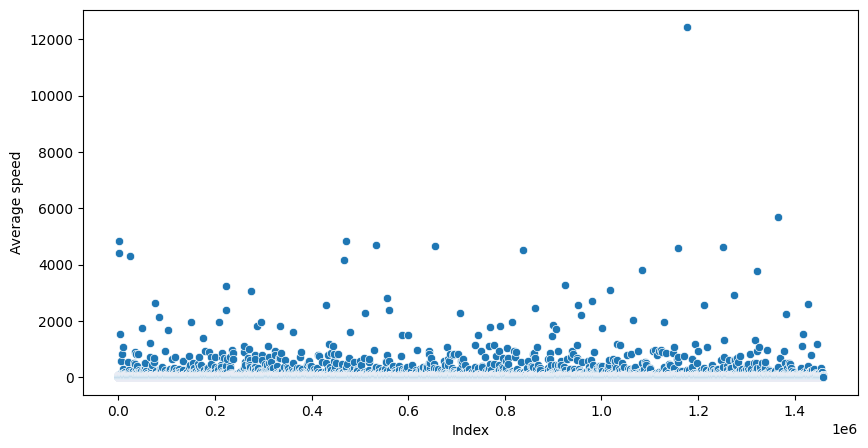

In [231]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [232]:
# ваш код здесь
duration_threshold = 86400
speed_threshold = 300

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

def outliers(data, feature, threshold):
    return data[data[feature] < threshold], data[data[feature] >= threshold]

taxi_data, duration_outliers = outliers(taxi_data, 'trip_duration', duration_threshold)
taxi_data, speed_outliers = outliers(taxi_data, 'avg_speed', speed_threshold)

In [233]:
duration_outliers.shape

(4, 27)

In [234]:
speed_outliers.shape

(406, 27)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [235]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [236]:
# ваш код здесь
from scipy.stats import normaltest
alpha = 0.05

_, p =normaltest(taxi_data['trip_duration_log'])

if p > alpha:
  print('Распределение нормальное. p =', p)
else:
  print('Распределение отлично от нормального. p =', p)

Распределение отлично от нормального. p = 0.0


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

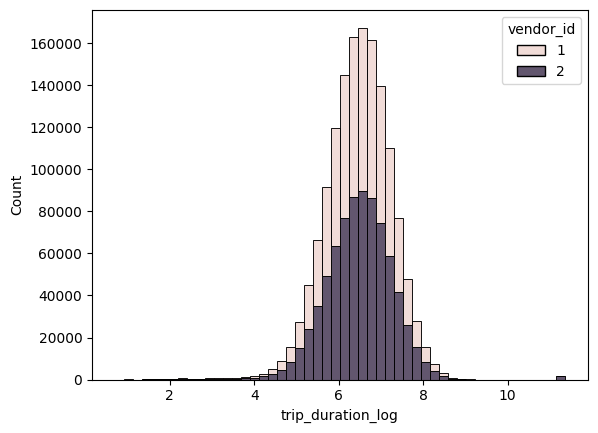

In [237]:
# ваш код здесь
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', bins=50, multiple='stack');

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

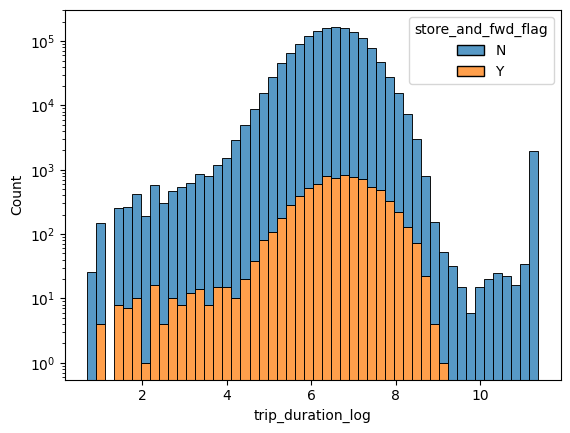

In [238]:
# ваш код здесь
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', bins=50, multiple='stack', log_scale=(False,True));

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

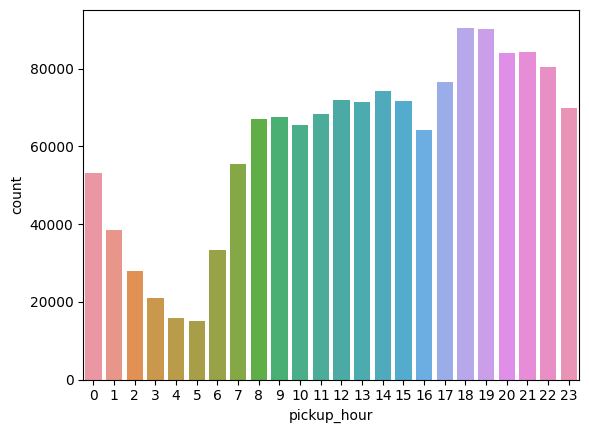

In [239]:
# ваш код здесь
sns.countplot(data=taxi_data, x='pickup_hour');

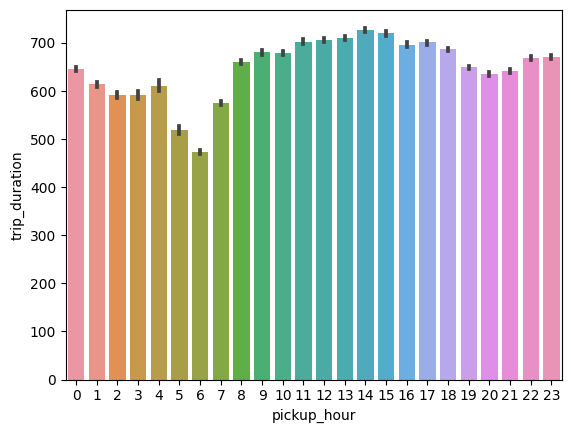

In [240]:
# ваш код здесь
sns.barplot(data=taxi_data, x='pickup_hour', y='trip_duration', estimator='median');

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


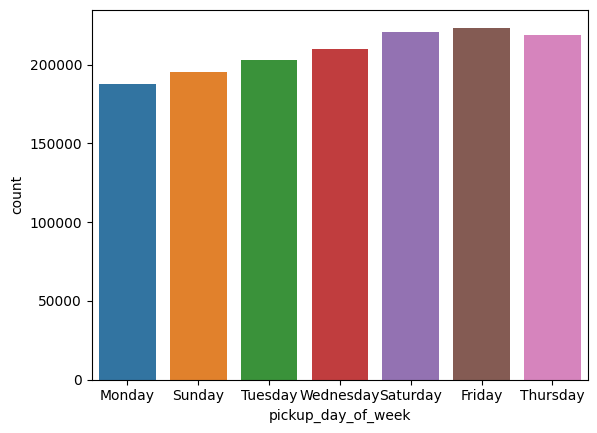

In [241]:
# ваш код здесь
sns.countplot(data=taxi_data, x='pickup_day_of_week');

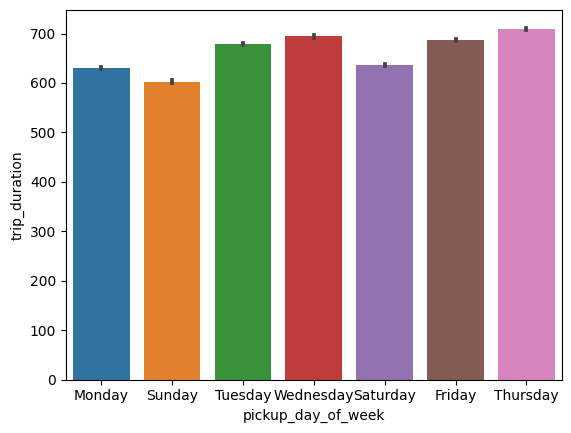

In [242]:
# ваш код здесь
sns.barplot(data=taxi_data, x='pickup_day_of_week', y='trip_duration', estimator='median');

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

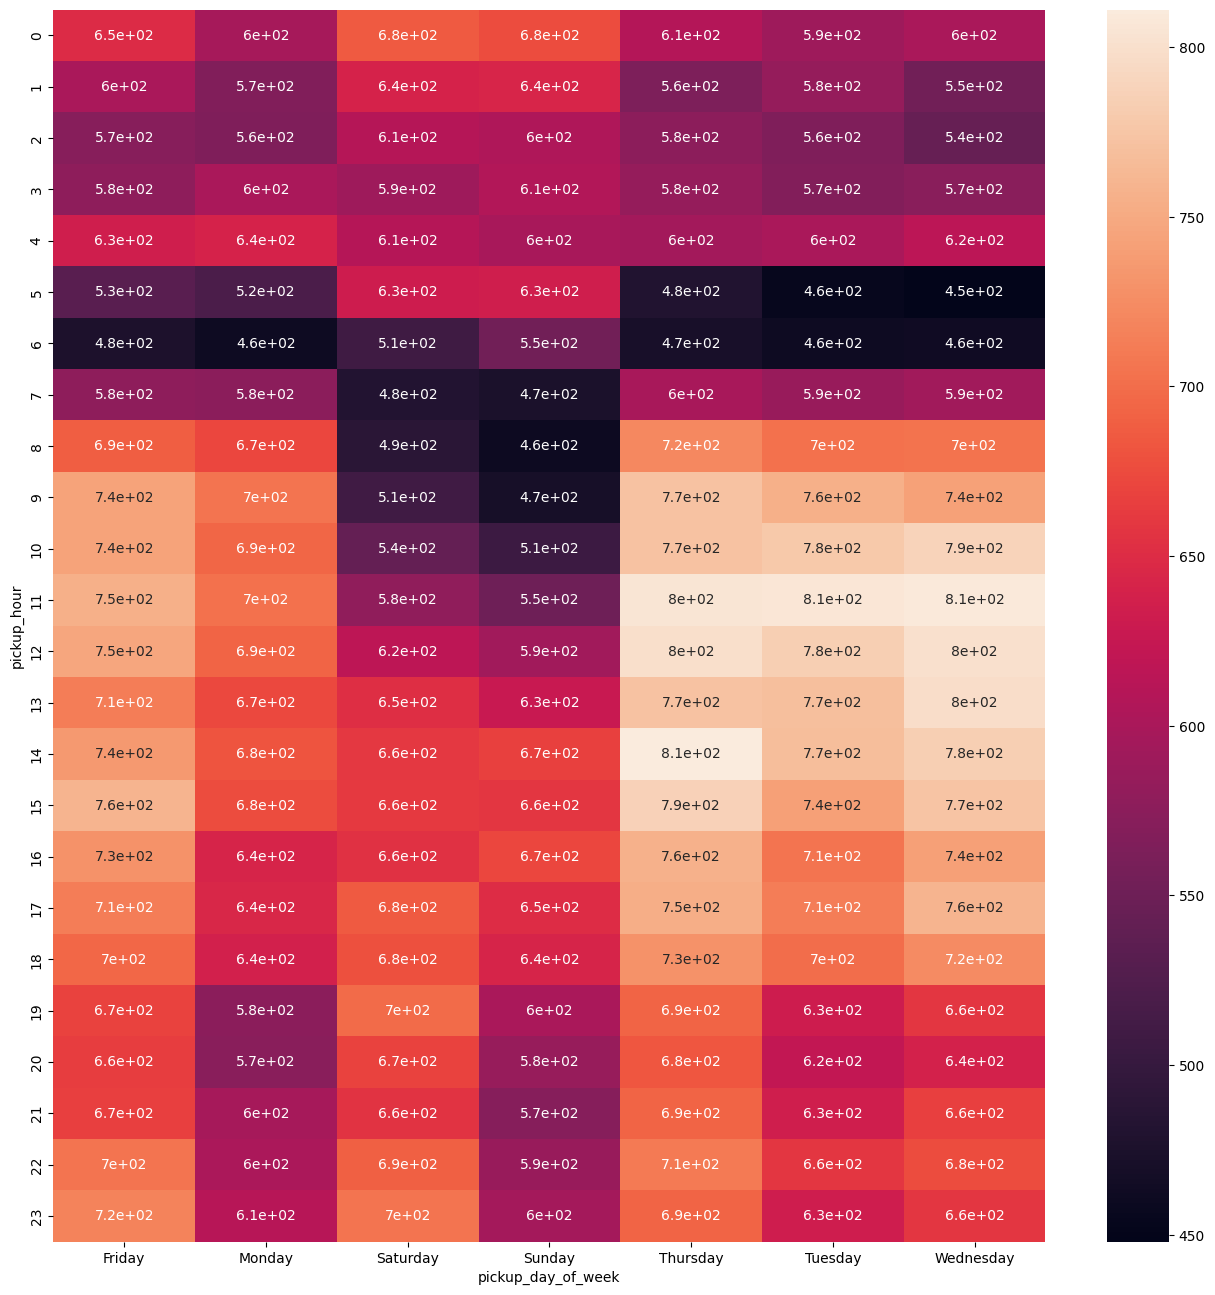

In [243]:
# ваш код здесь
plt.figure(figsize=(16,16))
pivot = pd.pivot_table(taxi_data[['trip_duration', 'pickup_hour', 'pickup_day_of_week']], index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')
pivot.columns = pivot.columns.droplevel(level=0)

sns.heatmap(pivot, annot=True);

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [244]:
city_lng_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь
taxi_data_border_dropoff = taxi_data[(taxi_data['dropoff_longitude'] < city_lng_border[1])&(taxi_data['dropoff_longitude'] > city_lng_border[0])]
taxi_data_border_dropoff = taxi_data_border_dropoff[(taxi_data_border_dropoff['dropoff_latitude'] < city_lat_border[1])&(taxi_data_border_dropoff['dropoff_latitude'] > city_lat_border[0])]
taxi_data_border_pickup = taxi_data[(taxi_data['pickup_longitude'] < city_lng_border[1])&(taxi_data['pickup_longitude'] > city_lng_border[0])]
taxi_data_border_pickup = taxi_data_border_pickup[(taxi_data_border_pickup['pickup_latitude'] < city_lat_border[1])&(taxi_data_border_pickup['pickup_latitude'] > city_lat_border[0])]

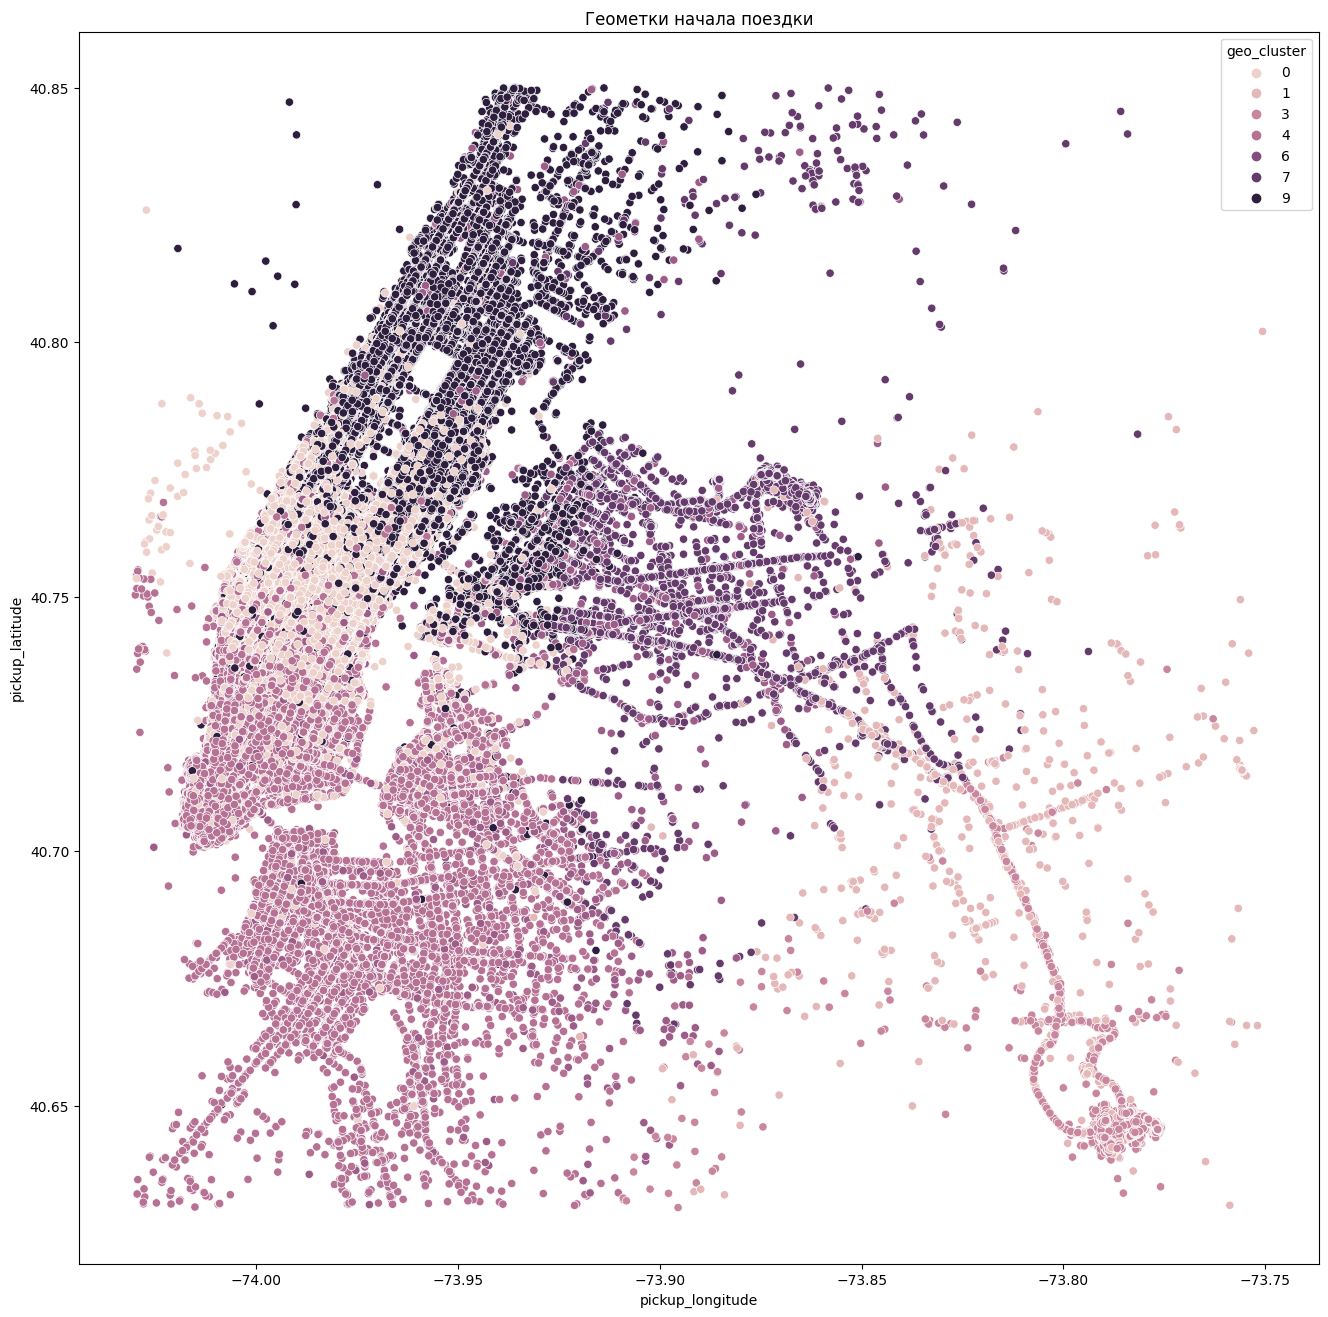

In [245]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=taxi_data_border_pickup, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster')
plt.title('Геометки начала поездки');

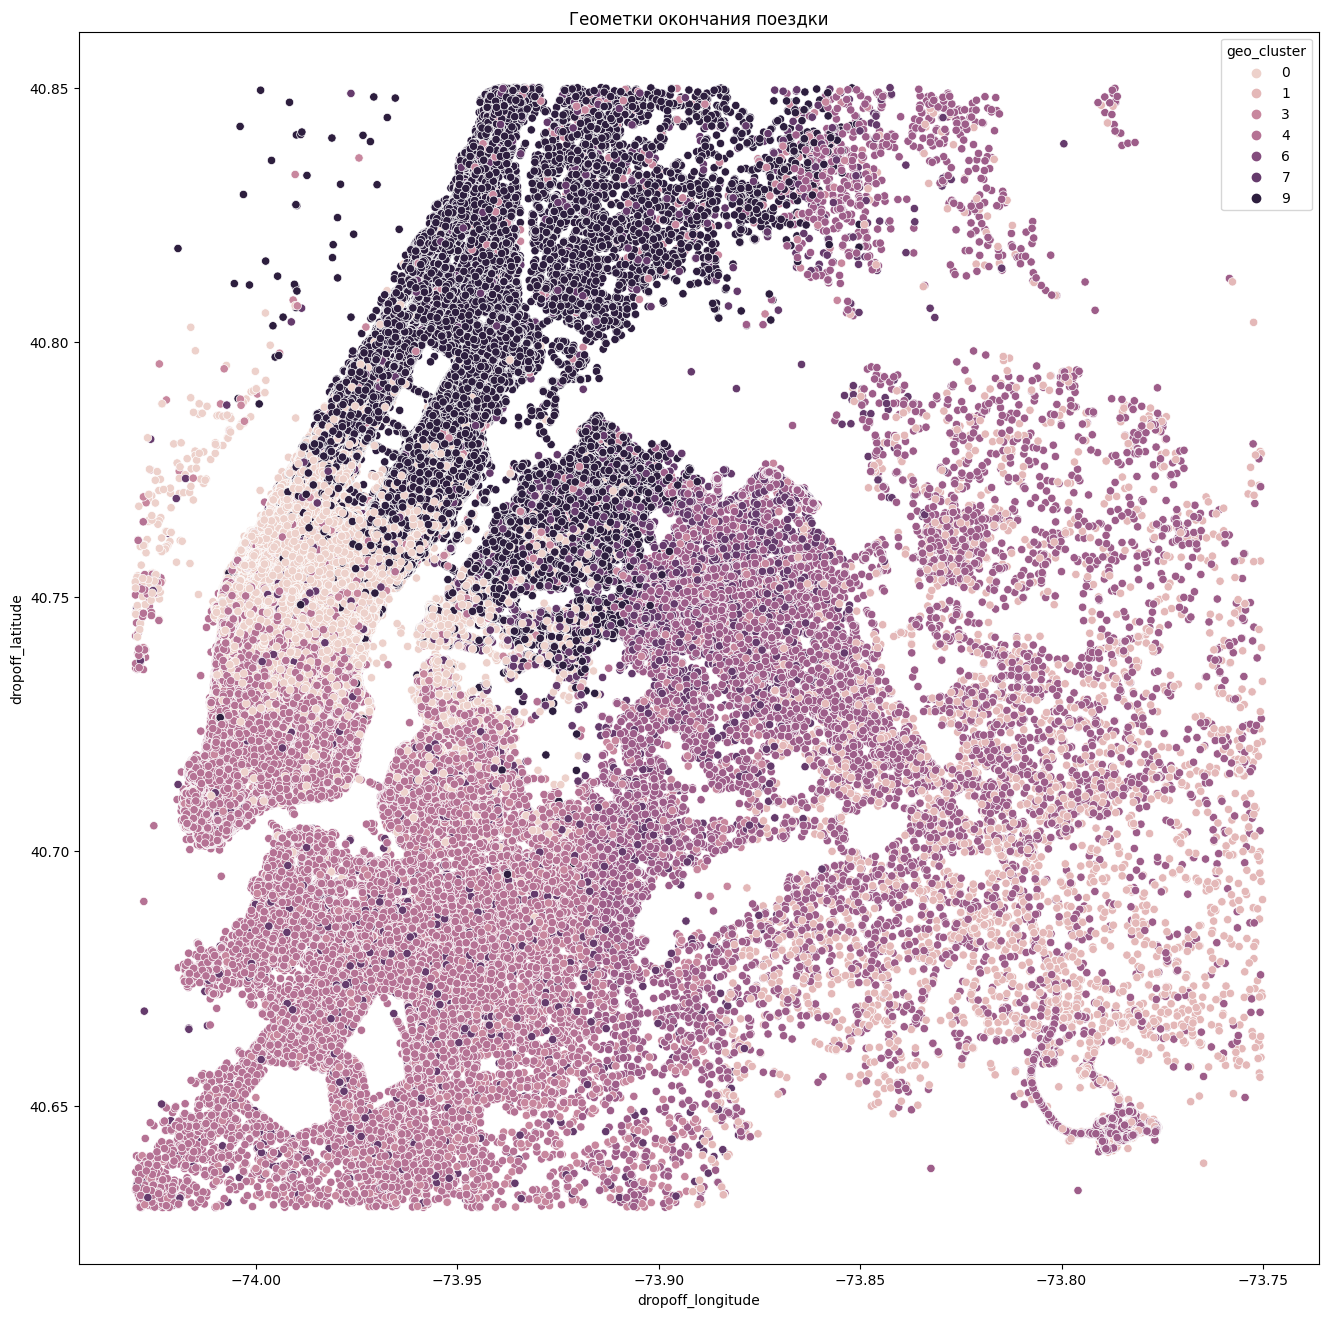

In [246]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=taxi_data_border_dropoff, x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster')
plt.title('Геометки окончания поездки');

In [247]:
taxi_data_border_dropoff['geo_cluster'].nunique()

7

In [248]:
taxi_data_border_pickup['geo_cluster'].nunique()

8

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [249]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'avg_speed', 'trip_duration_log'],
      dtype='object')


In [250]:
taxi_data = taxi_data.drop('avg_speed', axis=1)

Для удобства работы сделаем копию исходной таблицы с поездками:

In [251]:
train_data = taxi_data.copy()
train_data.reset_index(drop=True)
train_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction geo_cluster  temperature  visibility  \
0           1.498521   99.970196           9          4.4         8.0   
1           1.805507 -117.153768           4         28.9        16.1   
2           6.385098 -159.680165           4         -6.7        16.1   
3           1.485498 -172.737700           4          7.2        16.1   
4           1.188588  179.473585           9          9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [252]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [253]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [254]:
# ваш код здесь
train_data['vendor_id'] = train_data['vendor_id'] - 1
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 1 if x=='Y' else 0)

In [255]:
round(train_data['vendor_id'].mean(), 2)

0.53

In [256]:
round(train_data['store_and_fwd_flag'].mean(), 3)

0.006

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [257]:
# ваш код здесь
cols_to_code = ['pickup_day_of_week', 'geo_cluster', 'events']

encoder_onehot = preprocessing.OneHotEncoder(drop='first')

coded = train_data[cols_to_code]
coded = encoder_onehot.fit_transform(coded)

data_onehot = pd.DataFrame(coded.toarray(), columns=encoder_onehot.get_feature_names_out())
data_onehot

pickup_day_of_week_Monday  pickup_day_of_week_Saturday  \
0                              1.0                          0.0   
1                              0.0                          0.0   
2                              0.0                          0.0   
3                              0.0                          0.0   
4                              0.0                          1.0   
...                            ...                          ...   
1458228                        0.0                          0.0   
1458229                        0.0                          0.0   
1458230                        0.0                          0.0   
1458231                        0.0                          0.0   
1458232                        0.0                          0.0   

         pickup_day_of_week_Sunday  pickup_day_of_week_Thursday  \
0                              0.0                          0.0   
1                              1.0                          0.0   
2                              0.0                          0.0   
3                              0.0                          0.0   
4                              0.0                          0.0   
...                            ...                          ...   
1458228                        0.0                          0.0   
1458229                        1.0                          0.0   
1458230                        0.0                          0.0   
1458231                        0.0                          0.0   
1458232                        0.0                          0.0   

         pickup_day_of_week_Tuesday  pickup_day_of_week_Wednesday  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               1.0                           0.0   
3                               0.0                           1.0   
4                               0.0                           0.0   
...                             ...                           ...   
1458228                         0.0                           0.0   
1458229                         0.0                           0.0   
1458230                         0.0                           0.0   
1458231                         1.0                           0.0   
1458232                         1.0                           0.0   

         geo_cluster_1  geo_cluster_2  geo_cluster_3  geo_cluster_4  \
0                  0.0            0.0            0.0            0.0   
1                  0.0            0.0            0.0            1.0   
2                  0.0            0.0            0.0            1.0   
3                  0.0            0.0            0.0            1.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458228            0.0            0.0            0.0            0.0   
1458229            0.0            0.0            0.0            0.0   
1458230            0.0            0.0            0.0            1.0   
1458231            0.0            0.0            0.0            0.0   
1458232            0.0            0.0            0.0            0.0   

         geo_cluster_5  geo_cluster_6  geo_cluster_7  geo_cluster_8  \
0                  0.0            0.0            0.0            0.0   
1                  0.0            0.0            0.0            0.0   
2                  0.0            0.0            0.0            0.0   
3                  0.0            0.0            0.0            0.0   
4                  0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458228            0.0            0.0            0.0            0.0   
1458229            0.0            0.0            0.0            0.0   
1458230            0.0            0.0            0.0            0.0   
1458231

Добавим полученную таблицу с закодированными признаками:

In [258]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(cols_to_code, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [259]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [260]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [261]:
# ваш код здесь

selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
X_train = selector.fit_transform(X_train, y_train_log)
X_valid = selector.transform(X_valid)

best_features = X.columns[selector.get_support()]

X_train = pd.DataFrame(X_train, columns=best_features)
X_valid = pd.DataFrame(X_valid, columns=best_features)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [263]:
# ваш код здесь
scaler = preprocessing.MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

X_valid_scaled.iloc[:, 0].mean()

0.5354341180797852

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



In [264]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977016 entries, 0 to 977015
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977016 non-null  float64
 1   passenger_count               977016 non-null  float64
 2   pickup_longitude              977016 non-null  float64
 3   pickup_latitude               977016 non-null  float64
 4   dropoff_longitude             977016 non-null  float64
 5   dropoff_latitude              977016 non-null  float64
 6   store_and_fwd_flag            977016 non-null  float64
 7   pickup_hour                   977016 non-null  float64
 8   pickup_holiday                977016 non-null  float64
 9   total_distance                977016 non-null  float64
 10  total_travel_time             977016 non-null  float64
 11  number_of_steps               977016 non-null  float64
 12  haversine_distance            977016 non-nul

In [265]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481217 entries, 0 to 481216
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     481217 non-null  float64
 1   passenger_count               481217 non-null  float64
 2   pickup_longitude              481217 non-null  float64
 3   pickup_latitude               481217 non-null  float64
 4   dropoff_longitude             481217 non-null  float64
 5   dropoff_latitude              481217 non-null  float64
 6   store_and_fwd_flag            481217 non-null  float64
 7   pickup_hour                   481217 non-null  float64
 8   pickup_holiday                481217 non-null  float64
 9   total_distance                481217 non-null  float64
 10  total_travel_time             481217 non-null  float64
 11  number_of_steps               481217 non-null  float64
 12  haversine_distance            481217 non-nul

### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [266]:
# ваш код здесь
lr = linear_model.LinearRegression()

lr.fit(X_train_scaled, y_train_log)

y_train_log_pred = lr.predict(X_train_scaled)
y_valid_log_pred = lr.predict(X_valid_scaled)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.54
RMSLE на валидационной выборке 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [267]:
# ваш код здесь
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.fit_transform(X_valid_scaled)

X_train_scaled_poly = pd.DataFrame(X_train_scaled_poly, columns=poly.get_feature_names_out())
X_valid_scaled_poly = pd.DataFrame(X_valid_scaled_poly, columns=poly.get_feature_names_out())

lr_poly = linear_model.LinearRegression()

lr_poly.fit(X_train_scaled_poly, y_train_log)

y_train_log_pred = lr_poly.predict(X_train_scaled_poly)
y_valid_log_pred = lr_poly.predict(X_valid_scaled_poly)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.47
RMSLE на валидационной выборке 0.70


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [268]:
# ваш код здесь
ridge = linear_model.Ridge(alpha=1)

ridge.fit(X_train_scaled_poly, y_train_log)

y_train_log_pred = ridge.predict(X_train_scaled_poly)
y_valid_log_pred = ridge.predict(X_valid_scaled_poly)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.48
RMSLE на валидационной выборке 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [269]:
# ваш код здесь
dt = tree.DecisionTreeRegressor()

dt.fit(X_train_scaled, y_train_log)

y_train_log_pred = dt.predict(X_train_scaled)
y_valid_log_pred = dt.predict(X_valid_scaled)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.00
RMSLE на валидационной выборке 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


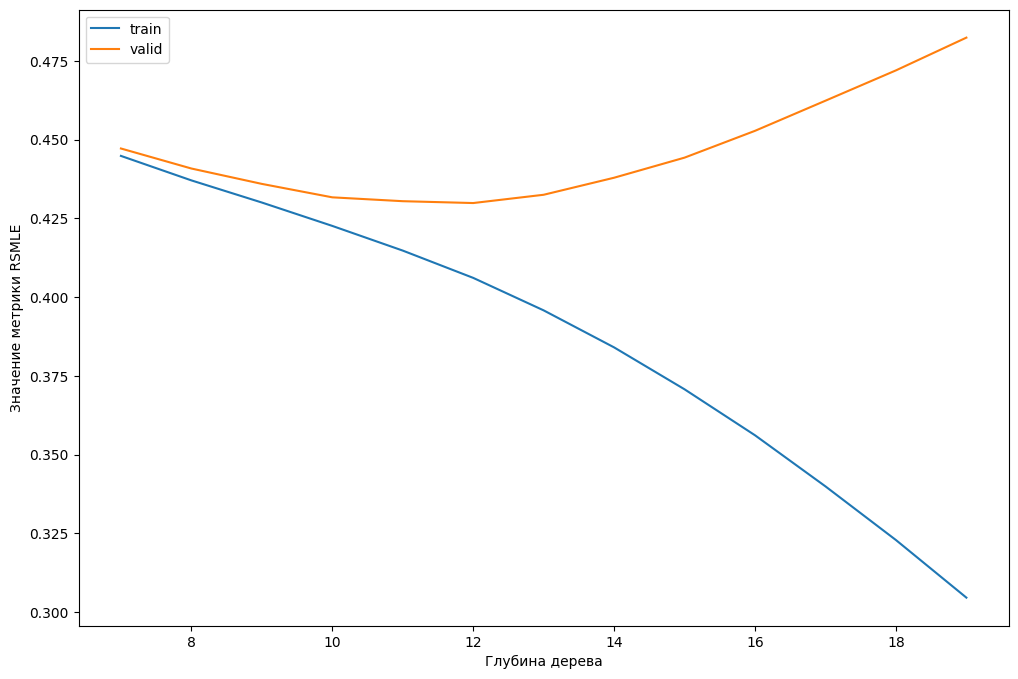

In [270]:
# ваш код здесь
max_depths = np.arange(7,20)
metrics_dict = {'depth':[], 'rmsle_train':[], 'rmsle_valid':[]}

for d in max_depths:
    metrics_dict['depth'].append(d)
    dt_ = tree.DecisionTreeRegressor(
        max_depth=d,
        random_state=42
    )
    dt_.fit(X_train_scaled, y_train_log)
    y_train_log_pred = dt_.predict(X_train_scaled)
    y_valid_log_pred = dt_.predict(X_valid_scaled)
    metrics_dict['rmsle_train'].append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred)))
    metrics_dict['rmsle_valid'].append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)))

metrics_dt = pd.DataFrame(metrics_dict)

plt.figure(figsize=(12,8))
sns.lineplot(data=metrics_dt, x='depth', y='rmsle_train', label='train')
sns.lineplot(data=metrics_dt, x='depth', y='rmsle_valid', label='valid')
plt.xlabel('Глубина дерева')
plt.ylabel('Значение метрики RSMLE')
plt.legend();

In [271]:
metrics_dt

depth  rmsle_train  rmsle_valid
0       7     0.444822     0.447174
1       8     0.437048     0.440817
2       9     0.430022     0.435937
3      10     0.422599     0.431669
4      11     0.414765     0.430444
5      12     0.406102     0.429857
6      13     0.395787     0.432485
7      14     0.384035     0.437893
8      15     0.370728     0.444272
9      16     0.356135     0.452781
10     17     0.339915     0.462347
11     18     0.322885     0.471967
12     19     0.304601     0.482365

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [272]:
# ваш код здесь
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',
    min_samples_split=20,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_log)

y_train_log_pred = rf.predict(X_train_scaled)
y_valid_log_pred = rf.predict(X_valid_scaled)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.40
RMSLE на валидационной выборке 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [273]:
# ваш код здесь
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    min_samples_split=30,
    max_depth=6,
    random_state=42
)
gb.fit(X_train_scaled, y_train_log)

y_train_log_pred = gb.predict(X_train_scaled)
y_valid_log_pred = gb.predict(X_valid_scaled)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_pred))

print('RMSLE на тренировочной выборке {:.2f}'.format(rmsle_train))
print('RMSLE на валидационной выборке {:.2f}'.format(rmsle_valid))

RMSLE на тренировочной выборке 0.37
RMSLE на валидационной выборке 0.39


Попробуем CatBoost:

In [328]:
from catboost import CatBoostRegressor

model_CAT = CatBoostRegressor(
    learning_rate=0.12,
    max_depth=8,
    iterations=7500,
    eval_metric='RMSE'
)
model_CAT.fit(
    X_train_scaled, y_train_log,
    eval_set=(X_valid_scaled, y_valid_log),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


In [329]:
best_model = model_CAT

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


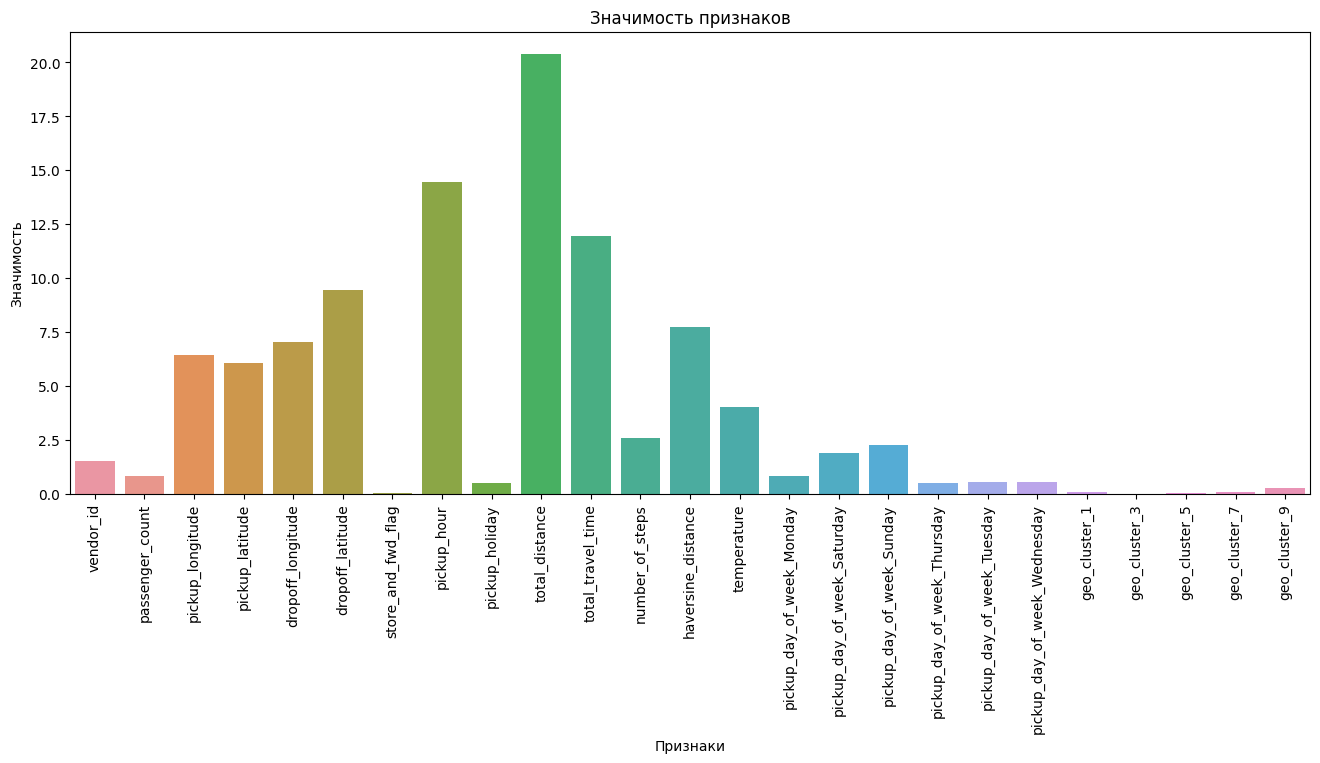

In [330]:
# ваш код здесь
def feat_draw(data, model):
    plt.figure(figsize=(16, 6))

    feature = data.columns
    feature_importances = model.feature_importances_ 

    sns.barplot(x=feature, y=feature_importances)
    plt.xlabel('Признаки')
    plt.ylabel('Значимость')
    plt.title('Значимость признаков')   
    plt.xticks(rotation=90);

feat_draw(X_train_scaled, best_model)

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [331]:
# ваш код здесь
y_valid_log_pred = best_model.predict(X_valid_scaled)

y_valid_exp = np.exp(y_valid_log) - 1
y_valid_exp_pred = np.exp(y_valid_log_pred) - 1

med_error = metrics.median_absolute_error(y_valid_exp, y_valid_exp_pred)

med_error_min = med_error / 60

print('MedianAE на вылидационной выборке (в минутах): {:.1f}'.format(med_error_min))

MedianAE на вылидационной выборке (в минутах): 1.7


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [314]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [315]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

test_data_onehot = encoder_onehot.fit_transform(test_data[cols_to_code]).toarray()
column_names = encoder_onehot.get_feature_names_out(cols_to_code)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(cols_to_code, axis=1), test_data_onehot], 
    axis=1
)

test_data = test_data.drop(['id', 'pickup_datetime'], axis=1)

X_test = test_data[best_features]

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print('Shape of data: {}'.format(X_test.shape))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [332]:
# ваш код здесь
y_test_predict = best_model.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [333]:
# Создание матриц наблюдений в формате DMatrix
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [334]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93575	valid-rmse:1.93569
[20]	train-rmse:0.78507	valid-rmse:0.78592
[30]	train-rmse:0.47892	valid-rmse:0.48093
[40]	train-rmse:0.42050	valid-rmse:0.42312
[50]	train-rmse:0.40890	valid-rmse:0.41187
[60]	train-rmse:0.40421	valid-rmse:0.40761
[70]	train-rmse:0.40130	valid-rmse:0.40512
[80]	train-rmse:0.39910	valid-rmse:0.40326
[90]	train-rmse:0.39715	valid-rmse:0.40159
[100]	train-rmse:0.39544	valid-rmse:0.40017
[110]	train-rmse:0.39415	valid-rmse:0.39928
[120]	train-rmse:0.39297	valid-rmse:0.39832
[130]	train-rmse:0.39152	valid-rmse:0.39718
[140]	train-rmse:0.39054	valid-rmse:0.39654
[150]	train-rmse:0.38924	valid-rmse:0.39552
[160]	train-rmse:0.38870	valid-rmse:0.39516
[170]	train-rmse:0.38805	valid-rmse:0.39483
[180]	train-rmse:0.38737	valid-rmse:0.39443
[190]	train-rmse:0.38648	valid-rmse:0.39376
[200]	train-rmse:0.38582	valid-rmse:0.39334
[210]	train-rmse:0.38518	valid-rmse:0.39316
[220]	train-rmse:0.38468	valid-rmse:0.39291

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [335]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39078


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

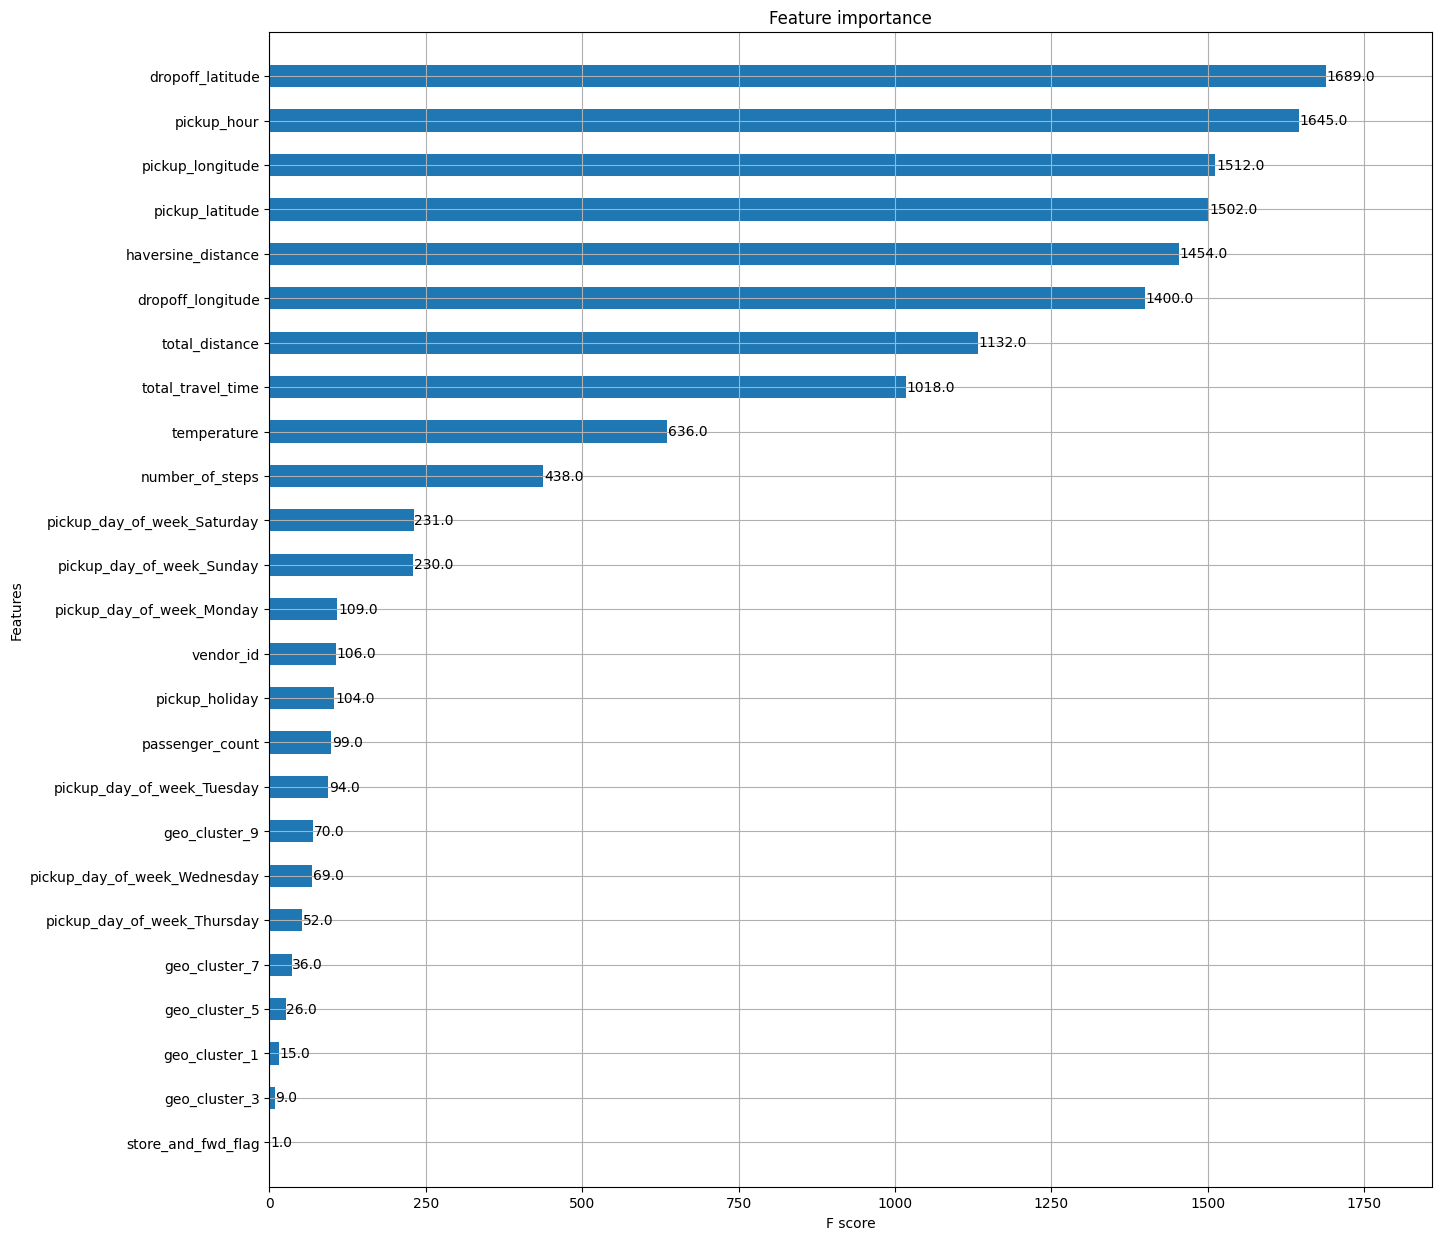

In [336]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)